In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import gauss

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics

from sklearn.metrics import RocCurveDisplay, auc

In [2]:
# load data
data0 = pd.read_csv("EC_METADATA_STEROID_PROFILING_LCMSMS_BIRMINGHAM_2023_FINAL_03July23.csv")

In [3]:
def binary_label_thr(label, thr):
    if label > thr:
        return 1
    else:
        return 0

def augment_data(data, labels, sigma, n):
    mu = 0
    num_instances = len(data)
    augmented_data = np.zeros( (n*num_instances, len(data[0])) )
    augmented_labels = np.zeros( (n*num_instances) )
    for i in range(n):
        augmented_data[i*num_instances:(i+1)*num_instances,:] = data
        augmented_labels[i*num_instances:(i+1)*num_instances] = labels
    for i in range(1,n):
        for j in range(num_instances):
            for k in range(len(augmented_data[i])):
                augmented_data[i*num_instances+j,k] = augmented_data[i*num_instances+j,k] + gauss(mu, sigma)
    return augmented_data, augmented_labels

In [4]:
complete_columns = []
for column in data0:
    num_missing = data0[column].isnull().sum()
    if num_missing > 0:
        print(f"{num_missing:2} {column} ")
    if num_missing == 0 and column != 'Grade':
        complete_columns.append(column)

In [5]:
# the first two columns (SampleID, Type) are excluded from the input variables of the model
ml_features = complete_columns[2:]

In [6]:
labels = []
for lab in data0["Type"]:
    if lab == 'Case':
        labels.append(1)
    elif lab == 'Control':
        labels.append(0)
    else:
        raise Exception(f"Unexpected label: {lab}")
labels = np.array(labels)

data = data0[ ml_features ]  
data = np.array(data)

In [7]:
transform = 'normalize' 
augment = True
features = [0,16,12] # selected features: BMI, 11bOHT_nM, T_nM 

In [9]:
num_outer_folds = 5
num_inner_folds = 5

#Parameters of data augmentation
sigma = 1
n = 10

all_auc = []
all_pred_train = []
all_labels_train = []
all_auc_train = []

sensitivity = []
specificity = []

tprs = []
mean_fpr = np.linspace(0, 1, 100)


for outer_fold in range(num_outer_folds):
    skf = StratifiedKFold(num_inner_folds, shuffle=True, random_state = outer_fold)
    splits = skf.split(data, labels)
    
    for train_idx, test_idx in splits:
        train_data = data[train_idx][:, features]
        train_labels = labels[train_idx]
        test_data = data[test_idx][:, features]
        test_labels = labels[test_idx]
        
        if transform=='normalize':
            col_means = np.mean(train_data,0)
            col_stds = np.std(train_data,0)
            for i in range(len(col_means)):
                train_data[:,i]=(train_data[:,i]-col_means[i])/col_stds[i]
                test_data[:,i]=(test_data[:,i]-col_means[i])/col_stds[i]
        elif transform!='none':
            raise Exception(f"Unknown transform: {transform}")
            

        if augment:
            train_data, train_labels = augment_data(train_data, train_labels, sigma, n )

        model = LogisticRegression(C=1, penalty='l2', max_iter=int(1e4), solver='liblinear') 
        model.fit(train_data, train_labels)
        
        pred = model.predict_proba(test_data)
        
        thr = 0.45
        binary_pred = np.array( [ binary_label_thr(pred[i,1], thr) for i in range(len(pred)) ] )
   
        tp = np.sum(np.logical_and(binary_pred == 1, test_labels==1))
        tn = np.sum(np.logical_and(binary_pred == 0, test_labels==0))
        fp = np.sum(np.logical_and(binary_pred == 1, test_labels==0))
        fn = np.sum(np.logical_and(binary_pred == 0, test_labels==1))
    
        sensitivity.append(tp / (tp+fn))
        specificity.append(tn / (tn+fp))
        
        fpr, tpr, _ = metrics.roc_curve(test_labels, pred[:,1] )
        roc_auc = metrics.auc(fpr, tpr)
        all_auc.append(roc_auc)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    
        pred_train = model.predict_proba(train_data)
        all_pred_train = all_pred_train + list(pred_train[:,1])
        all_labels_train = all_labels_train + list(train_labels)
        
        fpr, tpr, _ = metrics.roc_curve(train_labels, pred_train[:,1] )
        roc_auc = metrics.auc(fpr, tpr)
        all_auc_train.append(roc_auc)

In [10]:
np.std(all_auc)

0.06017698540902429

In [11]:
np.mean(sensitivity)

0.6646153846153847

In [12]:
np.std(sensitivity)

0.1008139132357565

In [13]:
np.mean(specificity)

0.6685714285714286

In [14]:
np.std(specificity)

0.09450191662023559

# ROC on TEST data

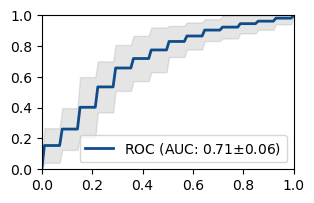

In [15]:
fig = plt.figure(figsize=(3.25, 2.00))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(all_auc)
plt.plot(
    mean_fpr,
    mean_tpr,
    color='#0f4c8aff',
    label=r"ROC (AUC: %0.2f$\pm$%0.2f)" % (mean_auc, std_auc),
    lw=2,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2
)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.savefig("ROC_cv_test_3.25x2.00.svg", format='svg')

 # ROC on TRAINING data

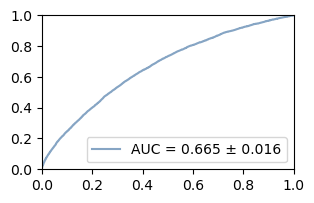

In [16]:
fpr, tpr, _ = metrics.roc_curve(all_labels_train, all_pred_train )
roc_auc = metrics.auc(fpr, tpr)
        
fig = plt.figure(figsize=(3.25, 2.00))
plt.plot(fpr, tpr, alpha=0.5, label = f'AUC = {roc_auc:0.3f} \u00B1 {np.std(all_auc_train):0.3f}', color='#0f4c8aff')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.savefig("ROC_cv_training_3.25x2.00.svg", format='svg')